# Exploratory Data Analysis

In this section, we seek to find any significant confounding factor that may drive the demand in specific location. This section will help us develop deeper understanding of the data and narrow down the significant features for our predictions/classifications later.

In [94]:
import sys
sys.path.append('../')
from scripts.preprocess import preprocess, transform_demand
from scripts.pluto_datascrape import get_merged_zone_data
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import BooleanType
import shapefile as shp
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import holidays


%matplotlib inline
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

In [2]:
# Starting a Spark session
spk = (
    SparkSession.builder.appName('Playground')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

# Read the parquet dataset
df = spk.read.parquet('/Users/oliver/Downloads/MAST30034_Python-main/data/tlc_data')


# TLC Taxi Dataset

In [3]:
# Clean the raw TLC taxi dataset
df = preprocess(df)

# Get the daily demand data
pickup_daily_demand, dropoff_daily_demand = transform_demand(df)


# Get the hourly demand data
pickup_hourly_demand, dropoff_hourly_demand = transform_demand(df, 'hour')

In [4]:
# Get total daily and hourly pickup demand data
print(f"Total of {pickup_daily_demand.count()} rows of daily pickup data\n"+
      f"Total of {pickup_hourly_demand.count()} rows of hourly pickup data\n")

Total of 41090 rows of daily pickup data
Total of 427910 rows of hourly pickup data



# PLUTO and TLC Zone Data

In [5]:
# Read the shapefile of the tlc zone dataset
sf = gpd.read_file("/Users/oliver/Downloads/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("/Users/oliver/Downloads/taxi_zones/taxi+_zone_lookup.csv")


In [6]:
# Merge the zone lookup csv and the shapefile
tlc_gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
).drop(['Zone','Borough'], axis=1)


In [7]:
# Get PLUTO and TLC Zone merged data
sjoined_df = get_merged_zone_data(sf, zones)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
../scripts/pluto_datascrape.py:97: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs + ...

  pluto_gdf, tlc_gdf, op='within'


In [8]:
# The merged data shows each individual lot information as well as
# which location id they are located within in the TLC zone data
sjoined_df.head()

,landuse,building_class,residential_units,non_residential_units,total_units,zipcode,latitude,longitude,geometry,location_id,service_zone,object_id,Shape_Leng,Shape_Area,zone,borough
0,1,A,1.0,0.0,1.0,11420,40.6780643,-73.8128145,POINT (-73.81281 40.67806),216,Boro Zone,216,0.116798,0.000816,South Ozone Park,Queens
1,1,A,1.0,0.0,1.0,11420,40.6758228,-73.8117212,POINT (-73.81172 40.67582),216,Boro Zone,216,0.116798,0.000816,South Ozone Park,Queens
2,1,A,1.0,0.0,1.0,11420,40.6775899,-73.8064237,POINT (-73.80642 40.67759),216,Boro Zone,216,0.116798,0.000816,South Ozone Park,Queens
3,1,B,2.0,0.0,2.0,11420,40.6759661,-73.8137901,POINT (-73.81379 40.67597),216,Boro Zone,216,0.116798,0.000816,South Ozone Park,Queens
4,1,B,2.0,0.0,2.0,11420,40.6777932,-73.8065240,POINT (-73.80652 40.67779),216,Boro Zone,216,0.116798,0.000816,South Ozone Park,Queens


The following function will be helpful in aggregating the number of buildings based on their `landuse`/`building_class` in each location id. This will help us to make some inference on the temporal pattern in certain location.

In [9]:
def sort_category_based_zone(groupby, op_column, operation):
    """
    Group and count the number of instances in the joined dataframe based on the category
    given in each location id.
    
    Param:
        groupby: column name in the PLUTO dataset to groupby
        op_column: column in PLUTO dataset to apply operation
        operation: aggregate operations such as 'sum', 'mean', 'count'...
        
    Output:
        dataframe: dataframe of operation applied on instances grouped by the category in each location id
    
    """
    
    # Groupby given column name and apply operation on the column specified
    count_category = sjoined_df.groupby(['location_id', groupby]).agg({op_column: operation})
    
    # Get all unique elements in the category
    category = sjoined_df[groupby].unique()
    
    tlc_gdf_v2 = tlc_gdf.copy()
    
    # Add columns for each given value in the category
    tlc_gdf_v2 = tlc_gdf_v2.reindex(columns = tlc_gdf.columns.tolist() + list(category))
    
    # 
    for idx, row in count_category.reset_index().iterrows():
        loc_id = row['location_id']
        cat = row[groupby]
        count = row[op_column]
        tlc_gdf_v2.loc[(tlc_gdf_v2['LocationID'] == loc_id), cat] = count 
    
    
    return tlc_gdf_v2

In [11]:
# Get the sum of residential units grouped by building classes in each location id
res_units_df = sort_category_based_zone('building_class', 'residential_units', 'sum')

# Get the sum of non-residential (office, retail, etc) units grouped by building
# classes in each location id
nonres_units_df = sort_category_based_zone('building_class', 'non_residential_units', 'sum')

# Get the sum of all units (res + non-res) grouped by building classes in each location id
total_units_df = sort_category_based_zone('building_class', 'total_units', 'sum')


In [12]:
total_lot_bc = sort_category_based_zone('building_class', 'geometry', 'count')

The building classes are encoded with alphabets (A-Z), the definition of the building classes code is as follow:
- A - ONE FAMILY DWELLINGS
- B - TWO FAMILY DWELLINGS
- C - WALK UP APARTMENTS
- D - ELEVATOR APARTMENTS
- E - WAREHOUSES
- F - FACTORY AND INDUSTRIAL BUILDINGS
- G - GARAGES AND GASOLINE STATIONS
- H - HOTELS
- I - HOSPITALS AND HEALTH
- J - THEATRES
- K - STORE BUILDINGS
- L - LOFT BUILDINGS
- M - CHURCHES, SYNAGOGUES, ETC.
- N - ASYLUMS AND HOMES
- O - OFFICE BUILDINGS
- P - PLACES OF PUBLIC ASSEMBLY (INDOOR) AND CULTURAL
- Q - OUTDOOR RECREATION FACILITIES
- R - CONDOMINIUMS
- S - RESIDENCE - MULTIPLE USE
- T - TRANSPORTATION FACILITIES (ASSESSED IN ORE)
- U - UTILITY BUREAU PROPERTIES
- V - VACANT LAND
- W - EDUCATIONAL STRUCTURES
- Y - SELECTED GOVERNMENT INSTALLATIONS
- Z - MISCELLANEOUS


Note that each tax lot has 1 building class which explains the **major** use of structure on the tax lot. Thus, there may be other usage within the building. For instance, a lot labelled `R` (CONDOMINIUM) may have non-residential units such as office and retail units within the building.

## Summary Statistics

In [14]:
# Tabulate summary statistics
operations = [func.mean, func.stddev, func.min, func.max]
exprs = [f(func.col("count")) for f in operations]

location_hourly_statistics = pickup_hourly_demand.groupby(['pu_location_id', 'pickup_date']).agg(*exprs)
location_daily_statistics = pickup_daily_demand.groupby('pu_location_id').agg(*exprs)

In [15]:
# Examine the statistics of daily demand focusing on mean and standard deviation
daily_std_desc = location_daily_statistics.sort(func.col("stddev_samp(count)").desc()).toPandas()
daily_avg_desc = location_daily_statistics.sort(func.col("avg(count)").desc()).toPandas()

In [17]:
avg_demand_building_class = pd.merge(daily_avg_desc,
                               total_lot_bc,
                               left_on='pu_location_id',
                               right_on='LocationID',
                               how='inner')

In [18]:
avg_demand_building_class['total_lot'] = avg_demand_building_class[sjoined_df['building_class'].unique()].sum(axis=1)

In [19]:
location_id = [row['pu_location_id'] for row in location_daily_statistics.select('pu_location_id').collect()]

In [20]:
set(tlc_gdf['LocationID']) - set(location_id)

{103, 110}

In [24]:
avg_demand_building_class['sqrt(count)'] = np.sqrt(avg_demand_building_class["avg(count)"])

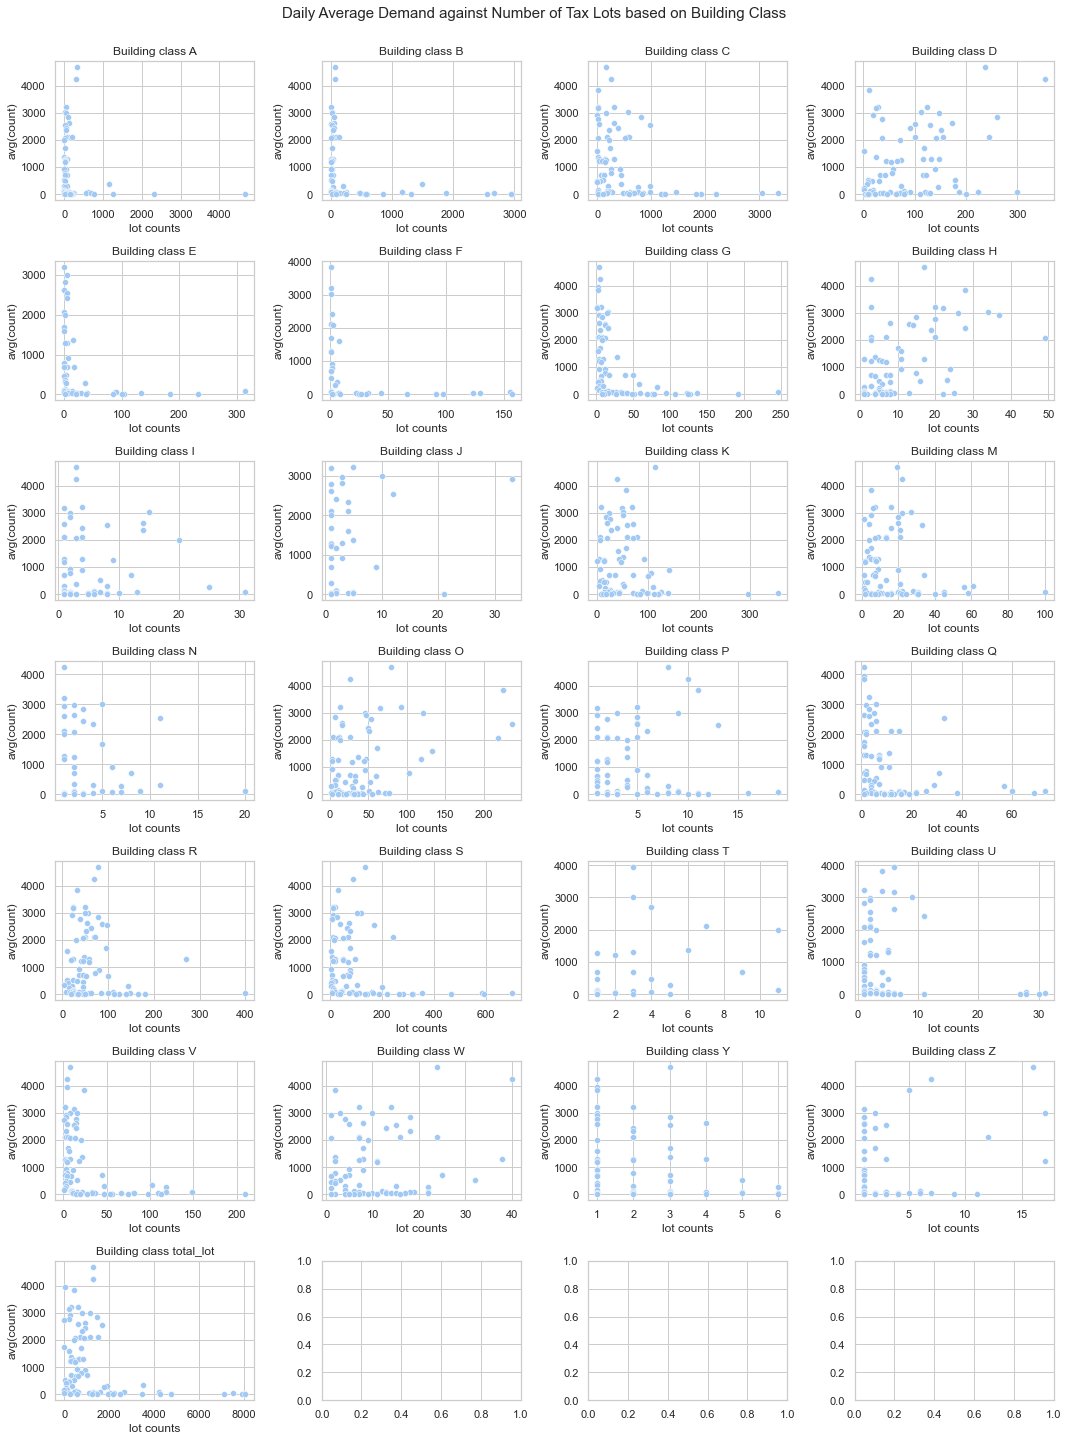

In [95]:
fig, ax = plt.subplots(7,4, figsize=(15,20))
row_idx = 0
col_idx = 0
categories = sorted(sjoined_df['building_class'].unique()) + ['total_lot']
for category in categories:
    sns.scatterplot(x=category, 
                    y='avg(count)', 
                    data=avg_demand_building_class[avg_demand_building_class['avg(count)']>10],
                    ax=ax[row_idx, col_idx])
    ax[row_idx, col_idx].set_xlabel('lot counts')
    ax[row_idx, col_idx].title.set_text(f'Building class {category}')

    col_idx += 1
    if col_idx > 3:
        col_idx = 0
        row_idx += 1

fig.suptitle("Daily Average Demand against Number of Tax Lots based on Building Class", fontsize=15, y=1)
plt.tight_layout()



Based on the plots above, only number of lots of `building_class` H (and arguably D) exhibit some linear relationship with average daily demand. This makes perfect sense since most travellers who stay in hotels will probably take the taxi if they are not taking the public transport. Thus, locations with more hotels will attract more demand for taxi rides.

Text(0.5, 1.0, 'Log Average Daily Demand for Yellow Taxi in NYC')

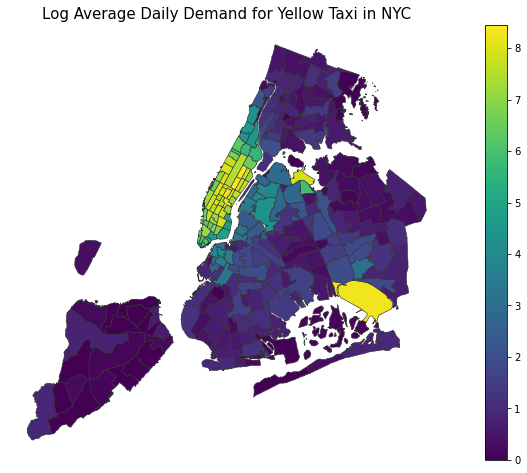

In [57]:
fig, ax = plt.subplots(1, figsize=(14,8))
gpd.GeoDataFrame(avg_demand_building_class).plot(column='log(count)', categorical=False, linewidth=.6, edgecolor='0.2',
         legend=True, ax=ax)
ax.axis('off')
plt.title('Log Average Daily Demand for Yellow Taxi in NYC', fontsize=15)



Immediately, we notice that on average most daily demand for yellow taxi cabs is concentrated in the city center at Manhattan (most densely populated location in NYC) and the two popular airports in New York, JFK and LaGuardia airports. Since the average daily pickup counts is highly skewed (eg. most locations apart from Manhattan have low average daily pickups), the log transformation on daily pickup counts can help reduce the skewness of our data.

## Daily pickups demand among boroughs

In this part, we will examine the pickup demands among boroughs. 

In [63]:
# Get all locations ids for each borough 
borough_id = {}
for borough in tlc_gdf['borough'].unique():
    borough_id[borough] = tlc_gdf[tlc_gdf['borough'] == borough]['LocationID'].unique().tolist()

In [74]:
# Get all daily and hourly pickup data for each borough
borough_daily_demand = {}
borough_hourly_demand = {}
for borough in borough_id.keys():
    borough_daily_demand[borough] = (pickup_daily_demand.filter(func.col('pu_location_id')
                                                        .isin(borough_id[borough]))
                                                        .toPandas())
    
    borough_hourly_demand[borough] = (pickup_hourly_demand.filter(func.col('pu_location_id')
                                                          .isin(borough_id[borough]))
                                                          .toPandas())


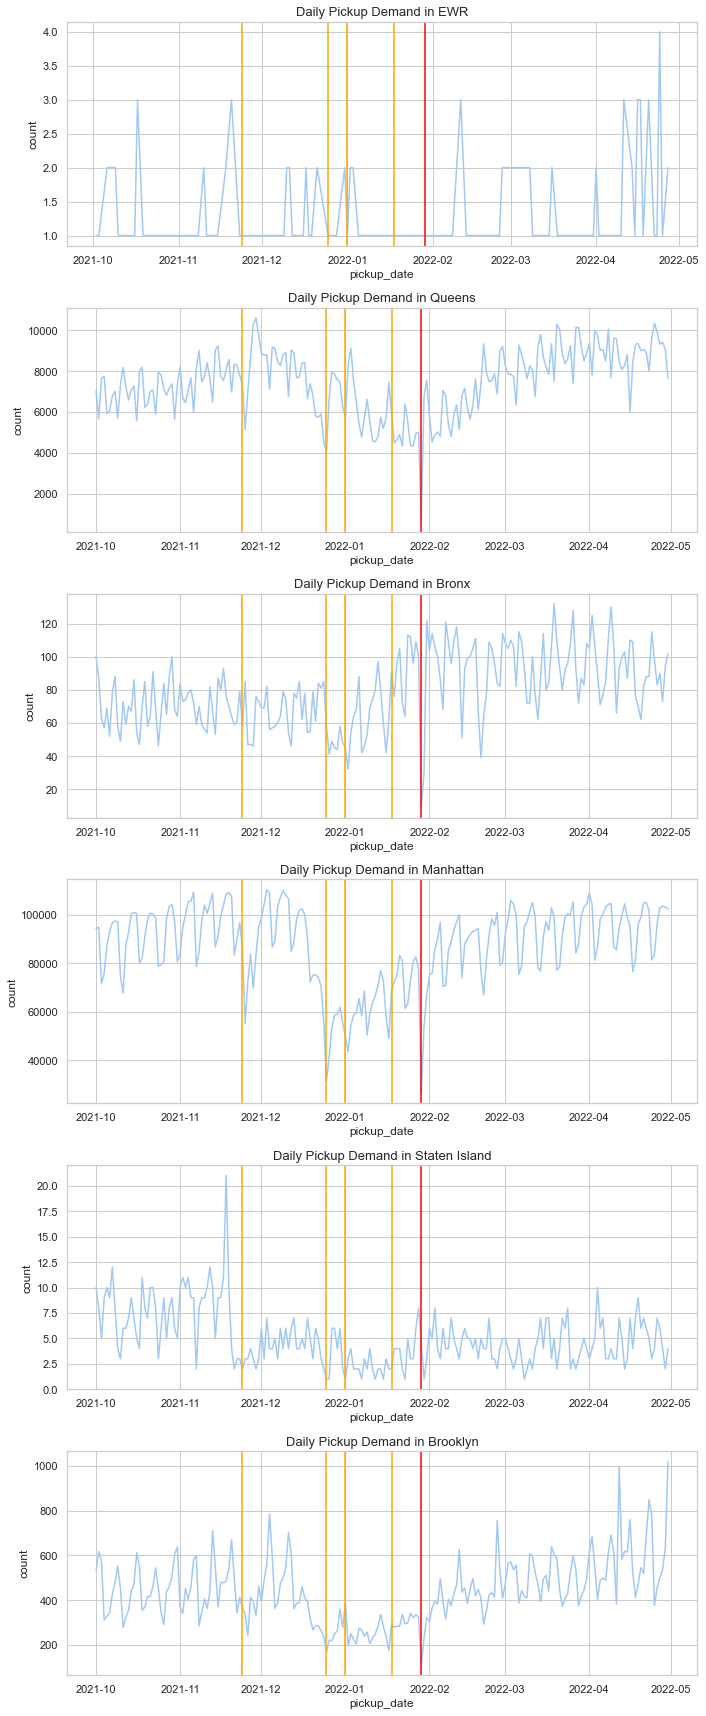

In [116]:
# Plot average daily demand in each borough
idx = 0
fig, ax = plt.subplots(len(borough_id.keys()), figsize=(10,24))
for borough in borough_id.keys():
    df = borough_daily_demand[borough].groupby('pickup_date').agg({'count':'sum'})
    sns.lineplot(x='pickup_date', y='count', data=df.reset_index(), ax=ax[idx])
    ax[idx].axvline(datetime.datetime(2021, 11, 24), color='orange')
    ax[idx].axvline(datetime.datetime(2021, 12, 25), color='orange')
    ax[idx].axvline(datetime.datetime(2022, 1, 1), color='orange')
    ax[idx].axvline(datetime.datetime(2022, 1, 18), color='orange')
    ax[idx].axvline(datetime.datetime(2022, 1, 29), color='red')
    ax[idx].set_title(f'Daily Pickup Demand in {borough}', fontsize=13)
    idx += 1

plt.tight_layout()

Based on the plots above, we can clearly see strong temporal patterns in the daily pickup demand among all boroughs. The Yellow vertical lines indicate federal holidays in NYC where as the Red vertical lines indicate a blizzard incident in NYC which significantly affected the demand of taxi rides. Overall, the daily pickup demand time series seem to be stationary in both mean and variance with exception to Brooklyn, Staten Island and Bronx where the volatility changes with time.

In [80]:
borough_hourly_demand['Manhattan']

,pu_location_id,pickup_date,pickup_hour,count
0,163,2022-03-01,8,99
1,88,2022-03-01,10,5
2,68,2022-03-01,11,128
3,43,2022-03-01,12,133
4,42,2022-03-01,16,9
...,...,...,...,...
288355,231,2022-01-28,12,42
288356,137,2022-01-28,19,146
288357,148,2022-01-30,1,55
288358,161,2022-01-31,12,201


Text(0.5, 1.0, 'Average Hourly Pickup Demand in each Location ID in Manhattan')

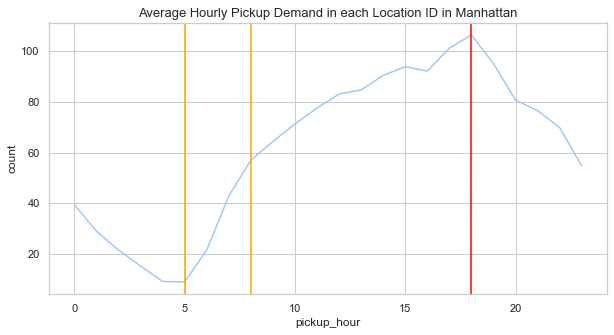

In [117]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.get_yaxis().get_major_formatter().set_scientific(False)
df_hourly = borough_hourly_demand['Manhattan'].groupby('pickup_hour').agg({'count':'mean'})
sns.lineplot(x='pickup_hour', y='count', data=df_hourly)
ax.axvline(5, color='orange')
ax.axvline(8, color='orange')
ax.axvline(18, color='red')
ax.set_title(f'Average Hourly Pickup Demand in each Location ID in Manhattan', fontsize=13)



Focusing on the hotspots in Manhattan, we observe that the demand is at its lowest around 4-5am and slowly pick up after 5am and peak at 6pm.

In [118]:
# Create a column to categorise weekday and weekend/public holiday
us_holidays = holidays.US(state='NY', years=[2021,2022])

# Expression to check if day is weekday or weekend/public holiday
is_weekday = ((func.dayofweek(func.col('pickup_date')).between(2,6)) 
             & (~func.col('pickup_date').isin(list(us_holidays.keys()))))

pickup_daily_demand = (pickup_daily_demand
                       .withColumn('year', func.year(func.col('pickup_date')))
                       .withColumn('month', func.month(func.col('pickup_date')))
                       .withColumn('day_of_month', func.dayofmonth(func.col('pickup_date')))
                       .withColumn('day_of_week', func.dayofweek(func.col('pickup_date')))
                       .withColumn('is_weekday', is_weekday)
)

In [130]:
location_weekday_statistics = (pickup_daily_demand.where(func.col('is_weekday') == True)
                                                  .groupby('pu_location_id')
                                                  .agg(*exprs)
                                                  .toPandas())

avg_weekday_demand = pd.merge(location_weekday_statistics,
                               total_units_df,
                               left_on='pu_location_id',
                               right_on='LocationID',
                               how='inner')

avg_weekday_demand['log(count)'] = np.log(avg_weekday_demand['avg(count)'])

In [131]:
location_weekend_statistics = (pickup_daily_demand.where(func.col('is_weekday') == False)
                                                  .groupby('pu_location_id')
                                                  .agg(*exprs)
                                                  .toPandas())

avg_weekend_demand = pd.merge(location_weekend_statistics,
                               total_units_df,
                               left_on='pu_location_id',
                               right_on='LocationID',
                               how='inner')

avg_weekend_demand['log(count)'] = np.log(avg_weekend_demand['avg(count)'])

In [ ]:
pickup_weekday_demand = pickup_daily_demand.where(func.col('weekday') == True)


In [ ]:
pickup_weekend_demand = pickup_daily_demand.where(func.col('weekday') == False)
pickup_weekend_demand

In [ ]:
total_lot_bc.columns

In [ ]:
merged_df = pd.merge(pickup_daily_demand.toPandas(),
                     total_lot_bc,
                     how='inner',
                     left_on='pu_location_id',
                     right_on='LocationID')

merged_df = merged_df[['count',
                       'pu_location_id',
                       'year',
                       'month',
                       'day_of_month',
                       'day_of_week',
                       'is_weekday',
                       'service_zone',
                       'zone',
                       'borough',
                       'geometry'] + 
                      list(sjoined_df['building_class'].unique())]

merged_df['total_lot'] = merged_df[list(sjoined_df['building_class'].unique())].sum(axis=1)

In [ ]:
merged_df[sjoined_df['building_class'].unique()] = merged_df[sjoined_df['building_class'].unique()].fillna(0)

In [ ]:
merged_df.to_csv("../data/curated/combined_data.csv", index=False)

In [ ]:
plt.hist(np.log(merged_df['count']))